# You can access this notebook using url - http://bit.ly/2oRqYeC

# 1 - Introduction

### What is OSMnx?

> A __Python package__ to download administrative boundary shapes and street networks from OSM.
>It is built over 
>###  *Networkx     +     Geopandas     +     Matplotlib*
>allowing for basic and extended __spatial statistical analysis and visualization__

>### *R-tree*
>allowing __fast__ spatial queries

### And what makes it special?

> __Automated downloading__ of boundary shapes, streets and building footprint

> Ability to extract street networks in __3 different formats__

### Cool! Let's see it in action ..

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import IFrame
from shapely.geometry import Point
from descartes import PolygonPatch
import folium

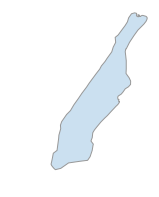

In [2]:
# get the boundary polygon for manhattan, save it as a shapefile, project it to UTM, and plot it
city = ox.gdf_from_place('Manhattan, New York City, New York, USA')
ox.save_gdf_shapefile(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

### This could be a county, city, state, country, continent or even a list of multiple places

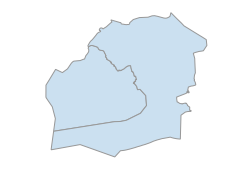

In [3]:
place_names = ['Brooklyn, New York City, New York, USA', 'Queens, New York City, New York, USA']
nyc = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(nyc, figsize=(3,3))

Brooklyn + Queens as per WGS84 co-ordinates

### Moving to streets..


Street networks can be downloaded by providing either
* A bounding box
* A lat-lon with distance
* Name(s) of place
* Address of place with distance
* Polygon for streets within

Street networks can be filtered for the following types
* 'drive'
* 'service'
* 'bike'
* 'walk'
* 'all' - default
* 'all_private'

#### A graph of street network for Manhattan

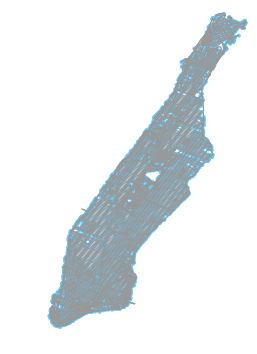

(<matplotlib.figure.Figure at 0x1f232cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17a36390>)

In [4]:
G1 = ox.graph_from_place('Manhattan, USA')
ox.plot_graph(G1)

#### A graph for driveable streets within a 1000 m radius around Carto (by Address)

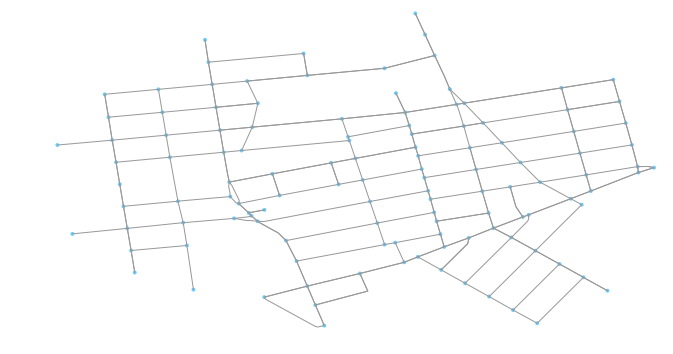

(<matplotlib.figure.Figure at 0x19aca898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b39c1d0>)

In [5]:
G2 = ox.graph_from_address('201 Moore St, Brooklyn, NY', distance=1000, distance_type='network', network_type='drive')
ox.plot_graph(G2)

#### A graph for streets within a 1000 m radius around Carto (by lat lon)

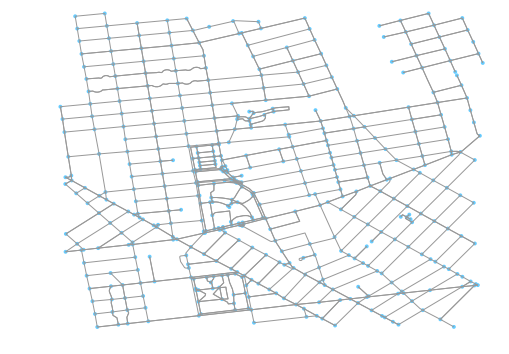

(<matplotlib.figure.Figure at 0x2609c198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2609cbe0>)

In [6]:
G3 = ox.graph_from_point((40.704667, -73.936701), distance=1000)
ox.plot_graph(G3)

### Can I save these graphs for later use?

There are 3 different file formats to save these graphs
* Shapefile
* GraphML file (to use in Gephi or NetworkX)
* SVG (to use in Illustrator)

# 2 - Examples
> ### *A. Basic spatial analysis*
> ### *B. Finding shortest distance from Carto to Google*
> ### *C. How far can I walk in 5, 10, 15 minutes from Carto?*
> ### *D. Extracting data ready for eternal use*

## *A. Basic Spatial Analysis*

### Categorizing streets around Carto based on street length

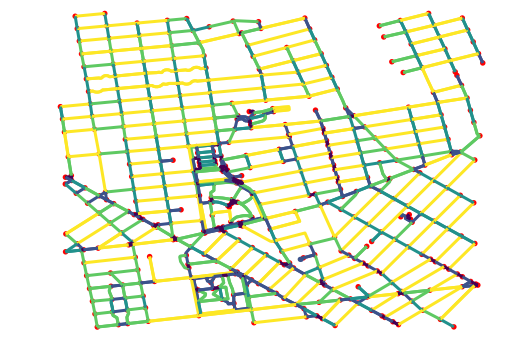

(<matplotlib.figure.Figure at 0x1a3c59b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19608320>)

In [7]:
color = ox.get_edge_colors_by_attr(G3, attr='length')
ox.plot_graph(G3, edge_color=color, node_color='r', node_size=30, edge_linewidth=3)

### Identifying streets as unidirectional or bidirectional

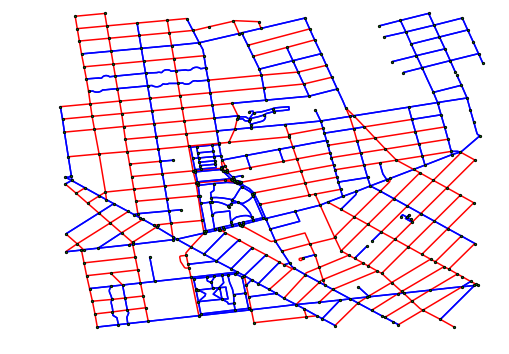

In [8]:
color = ['r' if data['oneway'] else 'b' for u, v, key, data in G3.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G3, node_color='g', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=color, edge_linewidth=1.5)

### Sneak peek into Street Network Statistics ..

In [9]:
#Calculating basic statistics
stats = ox.basic_stats(G1)
stats['circuity_avg']

1.0368762586669871

Im Manhattan the streets are 3.68% more circuitous than the straight line paths

In [10]:
# get the street network for a place, and its area in square meters
gdf = ox.gdf_from_place('Manhattan, USA')
area = ox.project_gdf(gdf).unary_union.area
G1 = ox.graph_from_place('Manhattan, USA', network_type='drive_service')

In [11]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G1, area=area)
extended_stats = ox.extended_stats(G1, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

avg_neighbor_degree                    {1773060097: 2.0, 1773060099: 3.0, 373268484: ...
avg_neighbor_degree_avg                                                          2.20555
avg_weighted_neighbor_degree           {1773060097: 0.0636997565913, 1773060099: 0.08...
avg_weighted_neighbor_degree_avg                                               0.0286467
betweenness_centrality                 {1773060097: 0.00382707245182, 1773060099: 0.0...
betweenness_centrality_avg                                                    0.00900715
center                                                                        [42431067]
circuity_avg                                                                      1.0246
closeness_centrality                   {1773060097: 0.000130257811937, 1773060099: 0....
closeness_centrality_avg                                                     0.000142179
clustering_coefficient                 {1773060097: 0.2, 1773060099: 0.0, 373268484: ...
clustering_coefficien

## *B. Finding shortest distance from Carto to Google*

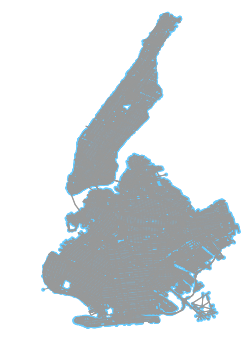

(<matplotlib.figure.Figure at 0x14762a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x95d1c0f0>)

In [12]:
#Create graph from list of places
place = ['Manhattan, New York City, USA', 'Brooklyn, New York City, USA']
G4 = ox.graph_from_place(place)
ox.plot_graph(G4)

In [13]:
#Provide coordinates and extract nodes
carto = (40.704667, -73.936701)
google_ny = (40.740881, -74.002017)
origin_node = ox.get_nearest_node(G4, carto)
destination_node = ox.get_nearest_node(G4, google_ny)
origin_node, destination_node

(42479990, 42435599)

In [14]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G4, origin_node, destination_node, weight='length')

In [15]:
# plot the route with folium
route_map = ox.plot_route_folium(G4, route)

In [16]:
# save as html file then display map as an iframe
filepath = 'osmnx_outputFiles/CartoRoute.html'
route_map.save(filepath)
IFrame(filepath, width=600, height=500)

Map Output:
![alt tab](https://raw.githubusercontent.com/ManushiM/CartoCamp_Workshops/master/osmnx_outputFiles/CartoRoute.PNG)

### And could I get the distance of this route?

In [17]:
# project the street network to UTM
G4_proj = ox.project_graph(G4)

In [18]:
#Calculate route length in metres and miles
route_lengths = ox.get_route_edge_attributes(G4_proj, route, 'length')
distance = int(np.sum(route_lengths))
print('Total trip distance : ' + str(distance) + ' metres or ' + str(int(distance * 0.0006213)) + ' miles')

Total trip distance : 8545 metres or 5 miles


## *C. How far can I walk in 5, 10, 15 minutes from Carto, Brooklyn?*

In [19]:
#setting basic configuration
network_type = 'walk'
trip_times = [5, 10, 15] #in minutes
travel_speed = 4.5 #walking speed in km/hour

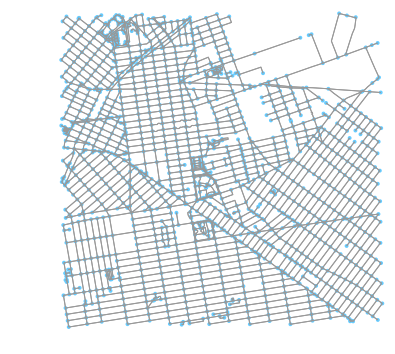

(<matplotlib.figure.Figure at 0x2a09fdd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a09f080>)

In [20]:
#Generating graph for a 2km radius around Carto
G5 = ox.graph_from_point(carto, distance=2000, network_type='walk')
G5 = ox.project_graph(G5)
ox.plot_graph(G5)

In [21]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Blues', start=0.3, return_hex=True)

In [22]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G5.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [23]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G5, origin_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

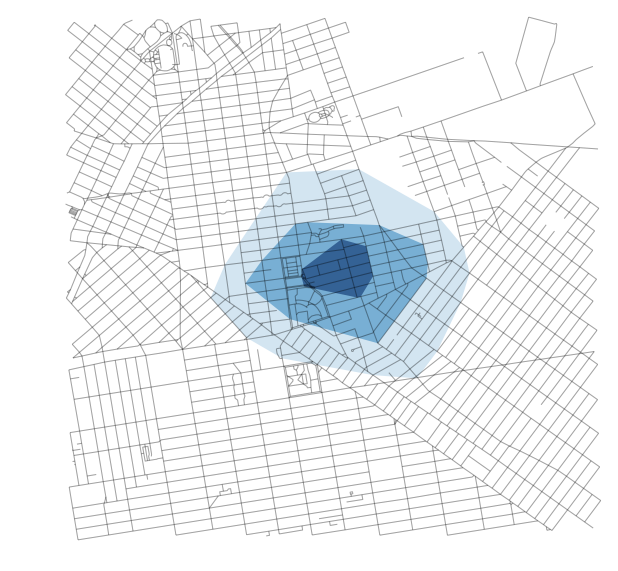

In [24]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G5, fig_height=10, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## *D. Extracting data for external use*

In [25]:
#Save the graph as a shapefile

ox.save_graph_shapefile(G5, filename='carto_osmnx')

In [26]:
#Read in the the streets as a geodataframe

streets_carto = gpd.read_file('data/carto_osmnx/edges/edges.shp')
streets_carto.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4871 entries, 0 to 4870
Data columns (total 15 columns):
access      70 non-null object
bridge      16 non-null object
from        4871 non-null object
geometry    4871 non-null object
highway     4871 non-null object
key         4871 non-null object
lanes       39 non-null object
length      4871 non-null object
maxspeed    169 non-null object
name        4336 non-null object
oneway      4871 non-null object
osmid       4871 non-null object
service     71 non-null object
time        4871 non-null object
to          4871 non-null object
dtypes: object(15)
memory usage: 570.9+ KB


In [27]:
#View the first 5 rows
streets_carto.head()

,access,bridge,from,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,service,time,to
0,None,None,42532947,LINESTRING (588884.458423364 4508223.166910326...,residential,0,None,29.4850562147,None,Manhattan Avenue,False,5681741,None,0.393134082862,42523210
1,None,None,42523210,LINESTRING (588884.458423364 4508223.166910326...,residential,1,None,29.4850562147,None,Manhattan Avenue,False,5681741,None,0.393134082862,42532947
2,None,None,42532947,LINESTRING (588884.458423364 4508223.166910326...,residential,0,None,79.1463208924,None,Manhattan Avenue,False,5681741,None,1.05528427857,42512070
3,None,None,42512070,LINESTRING (588884.458423364 4508223.166910326...,residential,1,None,79.1463208924,None,Manhattan Avenue,False,5681741,None,1.05528427857,42532947
4,None,None,42532947,LINESTRING (588884.458423364 4508223.166910326...,residential,0,None,115.828385979,None,Newton Street,False,5681480,None,1.54437847972,42467919


### Let's do the same for the node file too

In [28]:
#Read in the nodes as a geodataframe
nodes_carto = gpd.read_file('data/carto_osmnx/nodes/nodes.shp')
nodes_carto.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 5 columns):
geometry    1559 non-null object
highway     87 non-null object
lat         1559 non-null object
lon         1559 non-null object
osmid       1559 non-null object
dtypes: object(5)
memory usage: 61.0+ KB


In [29]:
#View first 5 rows
nodes_carto.head()

,geometry,highway,lat,lon,osmid
0,POINT (588762.3938877451 4507921.443980163),None,40.7174345,-73.9490648,42461444
1,POINT (588757.2188618743 4507947.294764155),None,40.7176679,-73.9491224,42461448
2,POINT (587981.9296207042 4507108.954401453),None,40.7102,-73.958418,42463268
3,POINT (588128.1513922678 4507128.964059621),traffic_signals,40.7103646,-73.9566844,42463272
4,POINT (588360.8560269822 4507364.712422704),None,40.7124631,-73.9538967,42463350


In [30]:
#Storing them as json files
street = streets_carto.to_json()
node = nodes_carto.to_json()

In [31]:
#Extracting the json files
with open('streets_carto.json', 'w') as f:
    f.write(street)
    
with open('nodes_carto.json', 'w') as f:
    f.write(node)

In [32]:
#Extracting the same data as CSV files
streets_carto.to_csv('streets_carto.csv')
nodes_carto.to_csv('nodes_carto.csv')

### The extracted files can then be plotted using Carto or D3 or any other supported tool

# 3 - Conclusion

> Extremely powerful, __multiple uses__

> __Automate collection and analysis__ of street networks

> Extract __specific and customized__ geographical data

> Make __presentation ready maps__ (folium web map)

# 4 - Credits

## Geoff Boeing!

> You can start with this [blog post](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
>
>
> And the GitHub repo for [OSMnx](https://github.com/gboeing/osmnx/)